In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from time import time

from models import Generator_FC, Generator_MNIST, Encoder, Decoder, Encoder_Mini, Decoder_Mini
from data import load_MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.autograd as autograd

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(batch_size=64)

In [4]:
load_mini = True
if not load_mini:
    # Load Encoder and Decoder
    run_fp = "runs/autoencoder"
    enc = Encoder(latent_size=100).to(device)
    dec = Decoder(latent_size=100).to(device)

    enc.load_state_dict(torch.load(os.path.join(run_fp, "enc.pth")))
    dec.load_state_dict(torch.load(os.path.join(run_fp, "dec.pth")))
else:
    # Load mini model
    run_fp = "runs/autoencoder_mini"
    enc = Encoder_Mini(latent_size=100).to(device)
    dec = Decoder_Mini(latent_size=100).to(device)

    enc.load_state_dict(torch.load(os.path.join(run_fp, "enc.pth")))
    dec.load_state_dict(torch.load(os.path.join(run_fp, "dec.pth")))

In [5]:
# Regular gradient ascent
def gradient_ascent(model, imgs, latent_dim, start_lr=10, iterations=1000, latent_vectors=None):
    """Perform gradient ascent on an image to find the optimal latent vector
    model: Generator taking (batch_size, latent_dim) -> (batch_size, 1, 28, 28)
    imgs: (batch_size, 1, 28, 28)
    latent_dim: int
    """
    batch_size = imgs.shape[0]
    # Setup latent vector
    if latent_vectors is None:
        latent_vectors = torch.randn(batch_size, latent_dim).to(device)
    latent_vectors.requires_grad = True

    # Setup optimizer and loss
    optimizer = optim.SGD([latent_vectors], lr=start_lr)
    criterion = nn.MSELoss()

    # Train
    model.eval()
    prev_loss = float("inf")
    for i in range(iterations):
        optimizer.zero_grad()
        output = model(latent_vectors)
        loss = criterion(output, imgs)
        loss.backward()
        optimizer.step()

        # if loss increases, stop
        if i % 100 == 0:
            if loss.item() > prev_loss - 1e-6:
                print("Loss increased, halving learning rate")
                start_lr /= 2
                if start_lr < 1:
                    print("Learning rate too small, breaking")
                    print(f"Iteration: {i} Loss: {loss.item()}")
                    break
                for param_group in optimizer.param_groups:
                    param_group['lr'] = start_lr
            prev_loss = loss.item()
        
        if i % 5000 == 0:
            print(f"Iteration: {i} Loss: {loss.item()}")

    return latent_vectors

In [36]:
# Get image
train_loader = private_loader
train_loader = public_loader
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)

In [37]:
# Run gradient ascent on decoder
latent_vectors = gradient_ascent(dec, imgs, 100, start_lr=100.0, iterations=200000)
gradient_ascent_imgs = dec(latent_vectors).cpu().detach().numpy()

Iteration: 0 Loss: 0.16952136158943176
Iteration: 5000 Loss: 0.007513873744755983
Iteration: 10000 Loss: 0.004683504346758127
Iteration: 15000 Loss: 0.003761919680982828
Iteration: 20000 Loss: 0.0033489142078906298
Iteration: 25000 Loss: 0.0030941690783947706
Iteration: 30000 Loss: 0.002917693927884102
Iteration: 35000 Loss: 0.002784996060654521
Iteration: 40000 Loss: 0.002682717051357031
Iteration: 45000 Loss: 0.0025959976483136415
Iteration: 50000 Loss: 0.002526914933696389
Iteration: 55000 Loss: 0.0024688192643225193
Loss increased, halving learning rate
Loss increased, halving learning rate
Loss increased, halving learning rate
Loss increased, halving learning rate
Loss increased, halving learning rate
Loss increased, halving learning rate
Loss increased, halving learning rate
Learning rate too small, breaking
Iteration: 57500 Loss: 0.002448276849463582


In [39]:
# Reconstruct image using encoder
autoencoder_imgs = dec(enc(imgs)).cpu().detach().numpy()

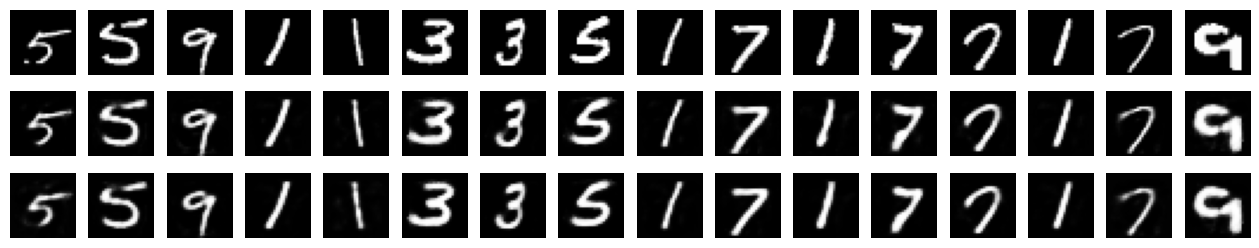

In [40]:
# Show first 16 images, gradient ascent, autoencoder
fig, axs = plt.subplots(3, 16, figsize=(16, 3))
for i in range(16):
    axs[0, i].imshow(imgs[i].cpu().detach().numpy().squeeze(), cmap="gray")
    axs[1, i].imshow(gradient_ascent_imgs[i].squeeze(), cmap="gray")
    axs[2, i].imshow(autoencoder_imgs[i].squeeze(), cmap="gray")
    for ax in axs[:, i]:
        ax.axis("off")
plt.show()

In [6]:
def projected_gradient_ascent(model, imgs, latent_dim, start_lr=1.0, iterations=100000, z_0_mult=1):
    """Perform projected gradient ascent on an image to find the optimal latent vector
    model: Generator taking (batch_size, latent_dim) -> (batch_size, 1, 28, 28)
    imgs: (batch_size, 1, 28, 28)
    latent_dim: int
    """
    batch_size = imgs.shape[0]
    # Setup latent vector
    latent_vectors = torch.randn(batch_size, latent_dim).to(device)
    latent_vectors.requires_grad = True

    # Sample z_0 and calculate P_Z(z_0)
    z_0 = torch.randn(batch_size, latent_dim).to(device) * z_0_mult
    norm_z_0 = torch.linalg.norm(z_0, dim=1)

    # Setup loss
    criterion = nn.MSELoss()

    # Train
    model.eval()
    prev_loss = float("inf")
    for i in range(iterations):
        latent_vectors.requires_grad = True
        output = model(latent_vectors)
        loss = criterion(output, imgs)

        # Compute gradient w.r.t. latent vector using autograd
        gradients = autograd.grad(
            outputs=loss,
            inputs=latent_vectors,
            grad_outputs=torch.ones_like(loss),
        )[0]

        # Gradient ascent step
        latent_vectors = latent_vectors - start_lr * gradients

        # Project latent vector back onto the sphere
        with torch.no_grad():
            norm_latent_vectors = torch.linalg.norm(latent_vectors, dim=1)
            scale = norm_latent_vectors / norm_z_0
            scale = torch.max(scale, torch.ones_like(scale))
            latent_vectors = latent_vectors / scale.unsqueeze(1)

        if i % 1000 == 0:
            # if loss increases, halve learning rate
            if loss.item() > prev_loss - 1e-6:
                print("Loss increased, halving learning rate")
                start_lr /= 2
                if start_lr < 1:
                    break
            prev_loss = loss.item()
        

        if i % 10000 == 0:
            print(f"Loss: {loss.item()}")

    return latent_vectors

In [7]:
# Load model
model = Generator_FC(hidden_sizes=[256], nz=100).to(device)
model.load_state_dict(torch.load(
    "runs_gen_fc_3/public_256_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0/netG_470000.pt"
))

<All keys matched successfully>

In [8]:
# Get image
train_loader = private_loader
# train_loader = public_loader
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)

In [9]:
imgs = imgs[:4]
# Make copy
imgs_copy = imgs.clone()
imgs.shape

torch.Size([4, 1, 28, 28])

In [10]:
# Perform projected gradient ascent
latent_vectors = projected_gradient_ascent(model, imgs, 100, start_lr=100.0, iterations=100000, z_0_mult=1)

# Print norms
norm_latent_vectors = torch.linalg.norm(latent_vectors, dim=1)
norm_latent_vectors

Loss: 0.11911074817180634
Loss: 0.033374249935150146


tensor([11.0388,  9.2391, 11.3845, 10.9418], device='cuda:0')

In [11]:
reconstructed_imgs = model(latent_vectors).cpu().detach().numpy()

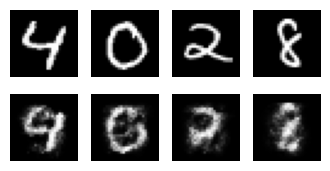

In [12]:
# Show first 16 images, projected gradient ascent, regular gradient ascent
fig, axs = plt.subplots(2, 4, figsize=(4, 2))
for i in range(4):
    axs[0, i].imshow(imgs[i].cpu().detach().numpy().squeeze(), cmap="gray")
    axs[1, i].imshow(reconstructed_imgs[i].squeeze(), cmap="gray")
    for ax in axs[:, i]:
        ax.axis("off")
plt.show()
